## TODO
* Re-write for more than two classes
* Add size binning: ingest lake size distrib
* First fix FI, then FM
* Monte Carlo sim to test all permutations; OR:
* Increment steps based on PDF, with each step having an equal prob.
* Jim's suggestion: try replacing EM with land, in addition to water, as I have it now
* install add-ons: git, variable inspector: first install node.js, npm, jupyterlab-git
* Find a plugin to make matplotlib plots interactive like when they appear in sep. window
* (contour plot: fill in color between lines) DONE

## Description
This script takes as input the landscape inundation fraction, the emergent macrophyte fraction (fraction of all inundated areas), and flux values for these fractions. It then iterates over probable ranges and plots the total flux's sensitivities to these values, Normalized by area.


| Name  | Description | Value |
|---      |---                |---       |
| INPUTS |
FLUXES | Dictionary of flux values by class	<mg CH4 / m2/ day>| OW: (0, 166); EM: (77, 5800)
FRACTION:IN_TOTAL | Fraction inundated: Range for open water and emergent macrophyte area divided by total landscape area | (10, 38)
FRACTION:EM | Fraction EMERGENT macrophyte: Range for emergent macrophyte area / open water area | (2, 60)
FRACTION:  ... | ...
FRACTION_STEPS | Number of steps for each landcover type (range / increment) |
FLUX_STEPS | Number of steps for flux (range / increment) |


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
import scipy.ndimage as ndi 
from scipy.io import loadmat
%matplotlib inline

### Inputs

In [61]:
# fluxes={'OW': 100,
#        'GW': 300,
#        'SW': 200}

FRACTION={
    'IN_TOTAL':(10, 38), # Fraction Inundated; From Run 35
    'EM':(2, 60) #(2, 30) # Fraction macrophyte: From Run 35 (range: 2:60)
}
FLUXES={
    'OW': (0, 166), # Open water; From range in: Burger et al 2016	Biogeosciences
    'EM': (77, 3000) #(77, 380)  # Emergent macrophyte; From mean (max = 5800) in: Burger et al 2016	Biogeosciences
}
FRACTION_STEPS=40
FLUX_STEPS=40
LAT=59 # latitude, in degrees (PAD=59)

### Lake size distribution inputs

Labels:
    'All'
    'Sagavanirktok River'
    'Yukon Flats Basin'
    'Old Crow Flats'
    'Mackenzie River Delta'
    'Mackenzie River Valley'
    'Canadian Shield Margin'
    'Canadian Shield'
    'Slave River'
    'Peace-Athabasca Delta'
    'Athabasca River'
    'Prairie Potholes North'
    'Prairie Potholes South'
    'Tuktoyaktuk Peninsula'
    []
    []
    []
    []
    []
    []
    []
    'Prairie pothole regions'
    'Canadian Shield'
    'Thermokarst regions'
    'Arctic-boreal wetlands'
    'Lowland river valleys'

In [26]:
lsd_pth='/mnt/d/GoogleDrive/Research/Lake distributions/savedData/fitting_data_regional_4_det.mat' # these directories hold the final version of data used for 2019 paper
lsd_labels_pth='/mnt/d/GoogleDrive/Research/Lake distributions/regionLabels4.mat'
region=9 # PAD

### Size binning data from Holgerson and Raymond 2016

In [70]:
BIN_EDGES=np.array([0, 0.001, 0.01, 0.1, 1, 10, 100, 10000000]) # <km2>
BIN_FLUXES=np.array([2.28, 0.65, 0.28, 0.16,  0.12, 0.10, 0.06])*16.043 # <mmolC (in CH4)/m2/d> * 16.043 = <mg CH4/m2/d>
len(BIN_FLUXES)

7

### Load data

In [43]:
fused_regional=loadmat(lsd_pth, variable_names='Fused_regional', squeeze_me=True)
lsd = fused_regional['Fused_regional'][region] # Lake size distribution for chosen region

##############
# for area for each region, see: D:\GoogleDrive\Research\Lake distributions\savedData\out
##############

### Create sensitivity raster

In [78]:
SENSITIVITY=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
# lsd_tmp=lsd # init
FRACTION_POSTINGS=np.linspace(FRACTION['EM'][0], FRACTION['EM'][1], FRACTION_STEPS)
FLUX_POSTINGS={}
for Class in FLUXES.keys():
    FLUX_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS)
for i in range(FRACTION_STEPS):
    lsd_tmp=lsd*(100-FRACTION_POSTINGS[i])/100 # change lake size distribution by swapping water for EM
    for j in range(FLUX_STEPS):
        SENSITIVITY[i,j] = np.mean(FRACTION['IN_TOTAL']) / 100 / 100 * (FRACTION_POSTINGS[i] * FLUX_POSTINGS['EM'][j] + # use median? # note: hard-coded for just two classes: OW and EM
                            (100- FRACTION_POSTINGS[i]) * np.mean(FLUX_POSTINGS['OW']))          
        

In [73]:
lsd-0.004
lsd_tmp=lsd*(100-FRACTION_POSTINGS[i])/100 # keeps decreasing in mag. each iteration as EM fraction grows # HERE # TODO: multiply rep fluxes * each lake area to get mean or total flux for every iteration
lsd
FLUX_POSTINGS['OW'][j]
FRACTION_POSTINGS
FLUX_POSTINGS['OW']

array([  0.        ,   4.25641026,   8.51282051,  12.76923077,
        17.02564103,  21.28205128,  25.53846154,  29.79487179,
        34.05128205,  38.30769231,  42.56410256,  46.82051282,
        51.07692308,  55.33333333,  59.58974359,  63.84615385,
        68.1025641 ,  72.35897436,  76.61538462,  80.87179487,
        85.12820513,  89.38461538,  93.64102564,  97.8974359 ,
       102.15384615, 106.41025641, 110.66666667, 114.92307692,
       119.17948718, 123.43589744, 127.69230769, 131.94871795,
       136.20512821, 140.46153846, 144.71794872, 148.97435897,
       153.23076923, 157.48717949, 161.74358974, 166.        ])

In [31]:
FRACTION_POSTINGS
FLUX_POSTINGS['OW'][j]
# FLUX_POSTINGS['EM'][j] 

166.0

Mean flux: 	128.2 mg CH_4/m^2/day
'Median' flux: 	188.9 mg CH_4/m^2/day

INPUTS:
FRACTION:	{'IN_TOTAL': (10, 38), 'EM': (2, 60)}
FLUXES:		{'OW': (0, 166), 'EM': (77, 3000)}

Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRaster.png


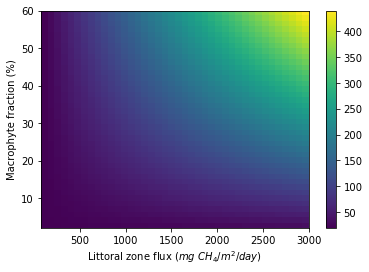

In [79]:
# plt.xticks(FLUX_POSTINGS[0:4:])
# plt.yticks(FRACTION_POSTINGS[0:4:])
p=plt.imshow(SENSITIVITY, origin='lower', aspect='auto', cmap='viridis', extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][0], FRACTION['EM'][1]))
plt.xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)")
plt.ylabel('Macrophyte fraction (%)')
plt.colorbar()
axes=plt.gca()
# plt.rcParams({'dpi':300})
# axes.set_xlim(FLUXES['EM'])
# axes.set_ylim(FRACTION['EM'])
# plt.xticks(FLUX_POSTINGS[0:4:])
# plt.yticks(FRACTION_POSTINGS[0:4:])

## calculate median:
cy, cx = ndi.center_of_mass(SENSITIVITY)

## report mean value:
print('Mean flux: \t{:.1f} mg CH_4/m^2/day'.format(np.mean(SENSITIVITY)))
print('\'Median\' flux: \t{:.1f} mg CH_4/m^2/day'.format(SENSITIVITY[cy.astype(int),cx.astype(int)])) # only equal to median if each step size is of equal prob.

print('''\nINPUTS:
FRACTION:\t{}
FLUXES:\t\t{}
'''.format(FRACTION, FLUXES))
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRaster.png'
plt.savefig(figPth, dpi=200)
print('Saved fig to:\t{}'.format(figPth))

Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.png


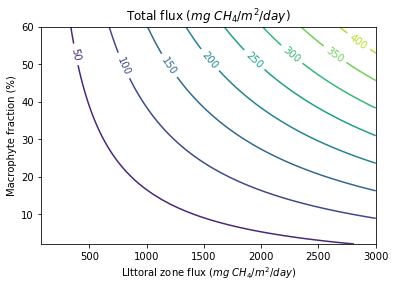

In [15]:
## Make contour plot
## TODO: fill in between lines
## from https://matplotlib.org/examples/pylab_examples/contour_label_demo.html

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

    # I/O
num_contours=10

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

##
plt.figure()

# define dims
Y=FRACTION_POSTINGS
X=FLUX_POSTINGS['EM']
Z=SENSITIVITY

# Basic contour plot
CS = plt.contour(X, Y, Z, num_contours)


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

# Recast levels to new class
CS.levels = [nf(val) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r'
else:
    fmt = '%r'
plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
plt.xlabel("LIttoral zone flux ($mg\ CH_4 / m^2 /day$)")
plt.ylabel('Macrophyte fraction (%)')
plt.title('Total flux ($mg\ CH_4 / m^2 /day$)')

# save

figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.png'
plt.savefig(figPth, dpi=200)
print('Saved fig to:\t{}'.format(figPth))

In [15]:
CS.levels

[0, 8, 16, 24, 32, 40, 48, 56]